This notebook contains the top-level code that performs secure inference on trained models. We use the models discussed in the dissertation. Note that the timing results here don't correspond to the results obtained in the evaluation. The results shown here are computed on a slightly different setup than the one used in the evaluation (so timing values may be different), and is just for demonstration purposes to show usage of the library's top level interface. The progress bars are not displayed correctly in the outputs due to a limitation of exporting Jupyter notebooks as PDFs. 

In [1]:
%pwd

'/home/han/Desktop/part-ii-project/part-ii-project/notebooks'

In [2]:
%cd ..

/home/han/Desktop/part-ii-project/part-ii-project


In [3]:
import numpy as np
from typing import List

from tqdm import tqdm

from utils.data_loader import load_data
from crypto.schemes import *
from model.lin_algebra import *
from model.creator import Creator
from model.revealer import Revealer
import math
import time
import torch
from keras.layers import ZeroPadding2D
import model.low_lat as low_lat
from utils.logger import msg, OutFlags

from model.model_builder import *
import matplotlib.pyplot as plt

### Low latency models

In [4]:
def mnist_fast(examples, mode='cifar'):
    if mode == 'normal':
        N = 512 * 16 * 1 * 1
        scheme, decryptor = init_scheme_ckks(N, primes=[32, 25, 25, 25, 25, 25, 32], scale_factor=25)
        creator = Creator(scheme)

        s = 2
        k = 5

        model = Model(creator)
        model.add(InputLayer(input_shape=(1, 30, 30)))
        model.add(ConvLayer(kernel_size=(k, k), stride=s, padding=0, num_maps=5, dense_mode=False))
        model.add(Flatten(groups=1))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=100, prev_channels=5))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=10))

        weights, test_features, preds_base, outputs_base = load_data(name='MNIST-CRYPTONETS-ORIGINAL')
        test_features = ZeroPadding2D()(test_features).numpy()

        model.compile(data_mode=1)
        model.load_weights(weights, scale=16)
        model.summary()
    elif mode == 'fast':
        N = 512 * 16 * 1 * 1
        scheme, decryptor = init_scheme_ckks(N, primes=[32, 28, 28, 28, 28, 28, 32], scale_factor=28)
        creator = Creator(scheme)

        s = 1
        k = 3

        model = Model(creator)
        model.add(InputLayer(input_shape=(1, 30, 30)))
        model.add(ConvLayer(kernel_size=(k, k), stride=s, padding=0, num_maps=5, dense_mode=False))
        model.add(Flatten(groups=1))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=32, prev_channels=5))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=10))

        weights, test_features, preds_base, outputs_base = load_data(name='MNIST-OPT')
        test_features = ZeroPadding2D()(test_features).numpy()

        model.compile(data_mode=1)
        model.load_weights(weights, scale=16)
        model.summary()
    elif mode == 'cifar-base':
        N = 512 * 16 * 2 * 1
        scheme, decryptor = init_scheme_ckks(N, primes=[60, 30, 30, 30, 30, 30, 30, 30, 30, 60], scale_factor=30)
        creator = Creator(scheme)

        s = 1
        k = 3

        model = Model(creator)
        model.add(InputLayer(input_shape=(3, 32, 32)))
        model.add(ConvLayer(kernel_size=(k, k), stride=s, padding=0, num_maps=18, dense_mode=False))
        model.add(Flatten(groups=5))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=4096, prev_channels=18))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=256))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=10))

        weights, test_features, preds_base, outputs_base = load_data(name='CIFAR-BASE')

        model.compile(data_mode=1)
        model.load_weights(weights, scale=16)
        model.summary()
    elif mode == 'cifar':
        N = 512 * 16 * 2 * 1
        scheme, decryptor = init_scheme_ckks(N, primes=[60, 30, 30, 30, 30, 30, 30, 30, 30, 60], scale_factor=30)
        creator = Creator(scheme)

        s = 1
        k = 3

        model = Model(creator)
        model.add(InputLayer(input_shape=(3, 32, 32)))
        model.add(ConvLayer(kernel_size=(k, k), stride=s, padding=0, num_maps=18, dense_mode=False))
        model.add(Flatten(groups=3))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=832, prev_channels=18))
        model.add(Unflatten(channels=13))
        model.add(ConvLayer(kernel_size=(1, 1), stride=1, padding=0, num_maps=64, dense_mode=False))
        model.add(Flatten(groups=1))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=256, prev_channels=64))
        model.add(ActivationLayer(mode='square'))
        model.add(DenseLayer(output_length=10))

        weights, test_features, preds_base, outputs_base = load_data(name='CIFAR-SVD')

        model.compile(data_mode=1)
        model.load_weights(weights, scale=16)
        model.summary()
        
    revealer = Revealer(scheme, decryptor)

    for i in examples:
        image = test_features[i]
        preds_base_i = preds_base[i]
        outputs_base_i = outputs_base[i]

        t0 = time.process_time()
        data = creator.encrypt_dense(mat=image)
        img_groups = creator.obtain_image_groups(mat=image, k=k, s=s)
        msg('Encryption', str(round(time.process_time() - t0, 4)), OutFlags.INFO)
        
        outputs = model.predict(input_data=img_groups)
        
        t0 = time.process_time()
        outputs = revealer.reveal_outputs(outputs, length=10, data_mode=1)
        msg('Decryption', str(round(time.process_time() - t0, 4)), OutFlags.INFO)

        output_probs = torch.softmax(torch.tensor(np.array(outputs, dtype=float)), 0).detach().numpy()

        msg('Result vs expected', str(np.argmax(outputs)) + ' ' + str(preds_base_i), OutFlags.INFO)
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        fig.suptitle('Final activations')
        axs[0].bar(np.arange(10), output_probs, label='decrypted', color='green')
        axs[1].bar(np.arange(10), outputs_base[i], label='expected')
        axs[0].set_xticks(np.arange(0, 10, 1))
        axs[1].set_xticks(np.arange(0, 10, 1))
        fig.legend()
        
        if np.argmax(outputs) != preds_base_i:
            msg('mnist_fast', 'incorrect prediction!', OutFlags.INFO)

This is the low latency MNIST model discussed in section 3.5.1

-------Summary of model-------
Name                       Input shape                Output shape               
input0                     (1, 30, 30)                (1, 30, 30)                
conv1                      (1, 30, 30)                (5, 28, 28)                
flatten2                   (5, 28, 28)                (1, 1, 3920)               
activation_square3         (1, 1, 3920)               (1, 1, 3920)               
dense4                     (1, 1, 3920)               (1, 1, 32)                 
activation_square5         (1, 1, 32)                 (1, 1, 32)                 
dense6                     (1, 1, 32)                 (1, 1, 10)                 
Encryption::0.0849
Applying layer::input0
Time elapsed::1e-05
Applying layer::conv1



Time elapsed::0.27683
Applying layer::flatten2
Flatten::apply_fast::channels per group: 5
Flatten::apply_fast::channels in last group: 5
Time elapsed::0.07785
Applying layer::activation_square3
Time elapsed::0.0088
Applying layer::dense4
DenseLayer::apply_fast::group size: 3920
DenseLayer::apply_fast::last group size: 3920



Time elapsed::0.51749
Applying layer::activation_square5
Time elapsed::0.00452
Applying layer::dense6
DenseLayer::apply_fast::group size: 32
DenseLayer::apply_fast::last group size: 32



Time elapsed::0.08024
Total inference time::0.9658
------Summary of operations------
Layer               #HOPS     #AddPC    #AddCC    #MulPC    #MulCC    #Rots     Time      
input0              -         -         -         -         -         -         -         
conv1               90        5         40        45        -         -         0.277     
flatten2            8         -         4         -         -         4         0.078     
activation_square3  1         -         -         -         1         -         0.009     
dense4              110       1         38        32        -         39        0.517     
activation_square5  1         -         -         -         1         -         0.005     
dense6              36        1         12        10        -         13        0.08      
Total               246       7         94        87        2         56        0.966     
Decryption::0.0005
Result vs expected::9 9


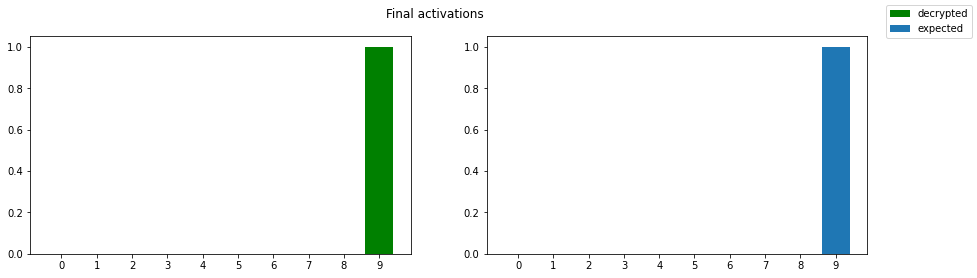

In [33]:
mnist_fast(examples=[12], mode='fast')

This is the result of evaluating the original CryptoNets architecture using the low-latency operations.

-------Summary of model-------
Name                       Input shape                Output shape               
input0                     (1, 30, 30)                (1, 30, 30)                
conv1                      (1, 30, 30)                (5, 13, 13)                
flatten2                   (5, 13, 13)                (1, 1, 845)                
activation_square3         (1, 1, 845)                (1, 1, 845)                
dense4                     (1, 1, 845)                (1, 1, 100)                
activation_square5         (1, 1, 100)                (1, 1, 100)                
dense6                     (1, 1, 100)                (1, 1, 10)                 
Encryption::0.2151
Applying layer::input0
Time elapsed::4e-05
Applying layer::conv1



Time elapsed::0.70051
Applying layer::flatten2
Flatten::apply_fast::channels per group: 5
Flatten::apply_fast::channels in last group: 5
Time elapsed::0.09468
Applying layer::activation_square3
Time elapsed::0.00912
Applying layer::dense4
DenseLayer::apply_fast::group size: 845
DenseLayer::apply_fast::last group size: 845



Time elapsed::1.80253
Applying layer::activation_square5
Time elapsed::0.00488
Applying layer::dense6
DenseLayer::apply_fast::group size: 100
DenseLayer::apply_fast::last group size: 100



Time elapsed::0.09608
Total inference time::2.70796
------Summary of operations------
Layer               #HOPS     #AddPC    #AddCC    #MulPC    #MulCC    #Rots     Time      
input0              -         -         -         -         -         -         -         
conv1               250       5         120       125       -         -         0.701     
flatten2            8         -         4         -         -         4         0.095     
activation_square3  1         -         -         -         1         -         0.009     
dense4              308       1         103       100       -         104       1.803     
activation_square5  1         -         -         -         1         -         0.005     
dense6              38        1         13        10        -         14        0.096     
Total               606       7         240       235       2         122       2.709     
Decryption::0.0007
Result vs expected::7 7


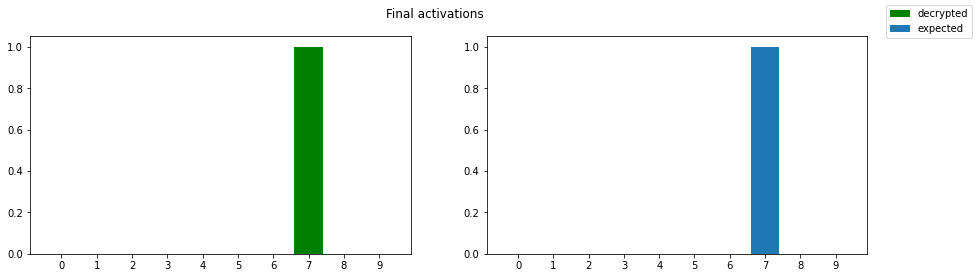

In [26]:
mnist_fast(examples=[0], mode='normal')

This is the low latency CIFAR model.

-------Summary of model-------
Name                       Input shape                Output shape               
input0                     (3, 32, 32)                (3, 32, 32)                
conv1                      (3, 32, 32)                (18, 30, 30)               
flatten2                   (18, 30, 30)               (1, 1, 16200)              
activation_square3         (1, 1, 16200)              (1, 1, 16200)              
dense4                     (1, 1, 16200)              (1, 1, 832)                
unflatten5                 (1, 1, 832)                (13, 8, 8)                 
conv6                      (13, 8, 8)                 (64, 8, 8)                 
flatten7                   (64, 8, 8)                 (1, 1, 4096)               
activation_square8         (1, 1, 4096)               (1, 1, 4096)               
dense9                     (1, 1, 4096)               (1, 1, 256)                
activation_square10        (1, 1, 256)                (1, 1, 256)  


Time elapsed::8.08185
Applying layer::flatten2
Flatten::apply_fast::channels per group: 6
Flatten::apply_fast::channels in last group: 6
Time elapsed::1.60951
Applying layer::activation_square3
Time elapsed::0.11224
Applying layer::dense4
DenseLayer::apply_fast::group size: 5400
DenseLayer::apply_fast::last group size: 5400



Time elapsed::258.40442
Applying layer::unflatten5
Time elapsed::0.39471
Applying layer::conv6



Time elapsed::10.85991
Applying layer::flatten7
Flatten::apply_fast::channels per group: 64
Flatten::apply_fast::channels in last group: 64
Time elapsed::2.22019
Applying layer::activation_square8
Time elapsed::0.02046
Applying layer::dense9
DenseLayer::apply_fast::group size: 4096
DenseLayer::apply_fast::last group size: 4096



Time elapsed::10.86958
Applying layer::activation_square10
Time elapsed::0.01002
Applying layer::dense11
DenseLayer::apply_fast::group size: 256
DenseLayer::apply_fast::last group size: 256



Time elapsed::0.20443
Total inference time::292.78742
------Summary of operations------
Layer               #HOPS     #AddPC    #AddCC    #MulPC    #MulCC    #Rots     Time      
input0              -         -         -         -         -         -         -         
conv1               972       18        468       486       -         -         8.082     
flatten2            30        -         15        -         -         15        1.61      
activation_square3  3         -         -         -         3         -         0.112     
dense4              7506      1         2504      2496      -         2505      258.404   
unflatten5          13        -         -         -         -         13        0.395     
conv6               1664      64        768       832       -         -         10.86     
flatten7            126       -         63        -         -         63        2.22      
activation_square8  1         -         -         -         1         -         0.02      
d

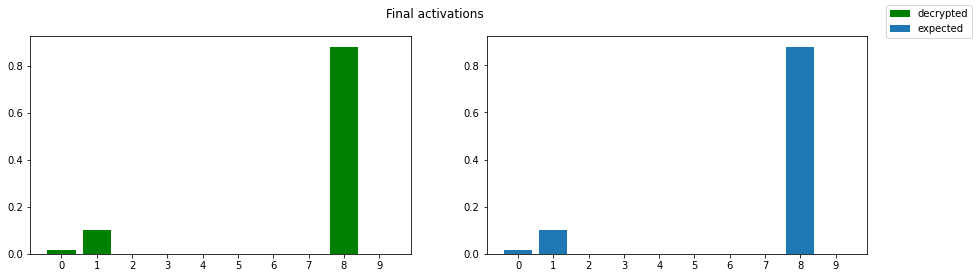

In [6]:
mnist_fast(examples=[1], mode='cifar')

In [ ]:
mnist_fast(examples=[1], mode='cifar-base')

### MNIST-SIMD

Here I show the unpruned high-throughput MNIST model (the original CryptoNets) and the pruned version using lottery pruning.

### Base model

In [7]:
N = 8192 * 1
scheme, decryptor = init_scheme_ckks(512 * 16 * 1 * 1, primes=[32, 25, 25, 25, 25, 25, 32], scale_factor=25)
creator = Creator(scheme)
revealer = Revealer(scheme, decryptor)

In [8]:
model = Model(creator)
model.add(InputLayer(input_shape=(1, 30, 30)))
model.add(ConvLayer(kernel_size=(5, 5), stride=2, padding=0, num_maps=5))
model.add(ActivationLayer(mode='square'))
model.add(Flatten(groups=1))
model.add(DenseLayer(output_length=100))
model.add(ActivationLayer(mode='square'))
model.add(DenseLayer(output_length=10))

weights, test_features, preds_base, outputs_base = load_data(name='MNIST-CRYPTONETS-ORIGINAL')

test_features = test_features[:N // 2]
preds_base = preds_base[:N // 2]
outputs_base = outputs_base[:N // 2]

test_features = ZeroPadding2D()(test_features).numpy()

model.compile(data_mode=0)
model.load_weights(weights, scale=16)
model.summary()

-------Summary of model-------
Name                       Input shape                Output shape               
input0                     (1, 30, 30)                (1, 30, 30)                
conv1                      (1, 30, 30)                (5, 13, 13)                
activation_square2         (5, 13, 13)                (5, 13, 13)                
flatten3                   (5, 13, 13)                (1, 1, 845)                
dense4                     (1, 1, 845)                (1, 1, 100)                
activation_square5         (1, 1, 100)                (1, 1, 100)                
dense6                     (1, 1, 100)                (1, 1, 10)                 


In [ ]:
print('Encrypting %s items' % len(test_features))

t0 = time.process_time()
model_input = creator.encrypt_simd(mat=test_features)
msg('Encryption', str(round(time.process_time() - t0, 4)), OutFlags.INFO)

outputs = model.predict(input_data=model_input)

In [35]:
outputs_d = revealer.reveal_outputs(outputs, N // 2, data_mode=0)
classes = np.argmax(outputs_d, axis=1)[0]

### Pruned model

In [5]:
N = 8192
scheme, decryptor = init_scheme_ckks(N, primes=[32, 25, 25, 25, 25, 25, 32], scale_factor=25)
creator = Creator(scheme)
revealer = Revealer(scheme, decryptor)

In [6]:
model = Model(creator)
model.add(InputLayer(input_shape=(1, 30, 30)))
model.add(ConvLayer(kernel_size=(5, 5), stride=2, padding=0, num_maps=5))
model.add(ActivationLayer(mode='square'))
model.add(Flatten(groups=1))
model.add(DenseLayer(output_length=100))
model.add(ActivationLayer(mode='square'))
model.add(DenseLayer(output_length=10))

weights, test_features, preds_base, outputs_base = load_data(name='LOTTERY')

In [7]:
test_features = test_features[:N // 2]
preds_base = preds_base[:N // 2]
outputs_base = outputs_base[:N // 2]

test_features = ZeroPadding2D()(test_features).numpy()

model.compile(data_mode=0)
model.load_weights(weights, scale=16)
model.summary()

-------Summary of model-------
Name                       Input shape                Output shape               
input0                     (1, 30, 30)                (1, 30, 30)                
conv1                      (1, 30, 30)                (5, 13, 13)                
activation_square2         (5, 13, 13)                (5, 13, 13)                
flatten3                   (5, 13, 13)                (1, 1, 845)                
dense4                     (1, 1, 845)                (1, 1, 100)                
activation_square5         (1, 1, 100)                (1, 1, 100)                
dense6                     (1, 1, 100)                (1, 1, 10)                 


In [10]:
print('Encrypting %s items' % len(test_features))

t0 = time.process_time()
model_input = creator.encrypt_simd(mat=test_features)
msg('Encryption', str(round(time.process_time() - t0, 4)), OutFlags.INFO)

outputs = model.predict(input_data=model_input)

Encrypting 4096 items



Encryption::8.039
Applying layer::input0
Time elapsed::2e-05
Applying layer::conv1




Time elapsed::35.78154
Applying layer::activation_square2
Time elapsed::7.38566
Applying layer::flatten3
Time elapsed::0.00084
Applying layer::dense4



Time elapsed::48.05838
Applying layer::activation_square5
Time elapsed::0.48586
Applying layer::dense6



Time elapsed::1.09185
Total inference time::92.80425
------Summary of operations------
Layer               #HOPS     #AddPC    #AddCC    #MulPC    #MulCC    #Rots     Time      
input0              -         -         -         -         -         -         -         
conv1               9971      845       3718      5408      -         -         35.782    
activation_square2  845       -         -         -         845       -         7.386     
flatten3            -         -         -         -         -         -         0.001     
dense4              24989     1         12394     12594     -         -         48.058    
activation_square5  100       -         -         -         100       -         0.486     
dense6              741       1         360       380       -         -         1.092     
Total               36646     847       16472     18382     945       -         92.805    


In [11]:
t0 = time.process_time()
outputs = revealer.reveal_outputs(outputs, 10, data_mode=0)
msg('Decryption', str(round(time.process_time() - t0, 4)), OutFlags.INFO)

Decryption::0.0173


In [12]:
classes = np.argmax(outputs, axis=1)[0]
accuracy(classes, preds_base)

1.0

### CryptoFace

The following is some old *test code* for the CryptoFace model left here for convenience. A better, updated demonstration is shown in CryptoFace.ipynb.

#### Set up parameters

In [ ]:
N = 8192 * 1
scheme = get_ckks_scheme(N, primes=[32, 25, 25, 25, 25, 25, 32], scale_factor=25)
creator = Creator(scheme)

In [ ]:
model = Model(creator)
model.add(InputLayer(input_shape=(2, 1, 64)))
model.add(SubLayer(size=64))
model.add(DenseLayer(output_length=64))
model.add(ActivationLayer(mode='square'))
model.add(DenseLayer(output_length=1))

In [31]:
weights = np.load('data/CRYPTOFACE_weights.npy', allow_pickle=True)

In [32]:
preds_base = preds_base[:N // 2]

model.compile(data_mode=0)
model.load_weights(weights, scale=16)
model.summary()

-------Summary of model-------
Input Layer, input shape = (2, 1, 64)
Difference layer, input shape = (2, 1, 64), output shape = (1, 1, 64)
Dense layer, input shape = (1, 1, 64), output shape = (1, 1, 64), weights shape = (64, 64)
Activation layer, mode = square, input shape = (1, 1, 64), output shape = (1, 1, 64)
Dense layer, input shape = (1, 1, 64), output shape = (1, 1, 1), weights shape = (64, 1)



#### Verify correctness 

In [71]:
def get_features(n):
    test_features = np.load('data/CRYPTOFACE_testpairs.npy')
    test_features = test_features[n * (N // 2): min((n + 1) * (N // 2), len(test_features))]
    test_features = test_features.reshape((test_features.shape[0], 1, 2, 64))
    test_features = test_features.transpose((0, 1, 3, 2))
    
    ps = np.load('data/CRYPTOFACE_preds.npy', allow_pickle=True)
    ps = ps[n * (N // 2): min((n + 1) * (N // 2), len(ps))]
    
    return test_features, ps

In [72]:
def to_binary(arr):
    arr_ = []
    for v in arr:
        arr_.append(int(round(v)))
    return arr_
        

sigmoid = lambda x : 1 / (1 + math.exp(-x))

In [73]:
def run_model(n):
    test_features, ps = get_features(n)
    
    outputs = model.predict(input_data=creator.encrypt_simd(mat=test_features),
                                 creator=creator, classes=N // 2)
    outputs = outputs[0, 0, :]
        
    print(accuracy(to_binary([sigmoid(o) for o in outputs]), to_binary(ps)))

In [74]:
run_model(0)


Layer 0::4.3283000024985085e-05
sub CC: 64
mult CC: 64
Layer 1::0.7123164829999951
-----Applying dense layer-----



multPC 4096
addCC 3968
addPC 1
Layer 2::18.286319747999983
square::::#mult-CC: 64
Layer 3::0.4123363620000191
-----Applying dense layer-----



multPC 64
addCC 62
addPC 1
Layer 4::0.2334852500000011
0.99365234375


In [70]:
run_model(1)


Layer 0::3.7061000000448985e-05
sub CC: 64
mult CC: 64
Layer 1::0.7125198580000074
-----Applying dense layer-----



multPC 4096
addCC 3968
addPC 1
Layer 2::18.557185877999984
square::::#mult-CC: 64
Layer 3::0.40945899100000815
-----Applying dense layer-----



multPC 64
addCC 62
addPC 1
Layer 4::0.23111194699998805
0.995361328125
